Estimating the value of a used car is one of the main everyday challenges in the automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability, and politics.
With this challenge, we hope to raise some interest in this exciting topic and also gain some insight into what the main factors are that drive the value of a used car.

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of cars that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## 0. Importing Libraries

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [96]:
df = pd.read_csv("data/bmw_pricing_challenge.csv")

In [97]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [98]:
df.shape

(4843, 18)

In [99]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contains any missing values.

In [100]:
print(df.isnull().sum())

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64


### 2.2. Distribution of the target variable

Plot the distribution of the target variable.

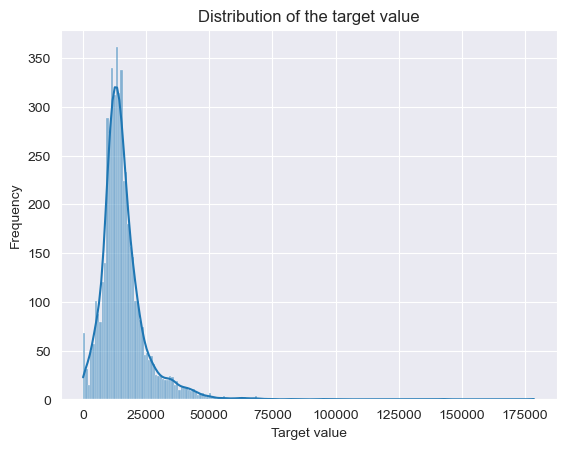

In [101]:
sns.histplot(data=df, x="price", kde=True)
plt.title('Distribution of the target value')
plt.xlabel('Target value')
plt.ylabel('Frequency')
plt.show()


### 2.3. Distribution of numerical variables

Plot the distribution of the numerical features.

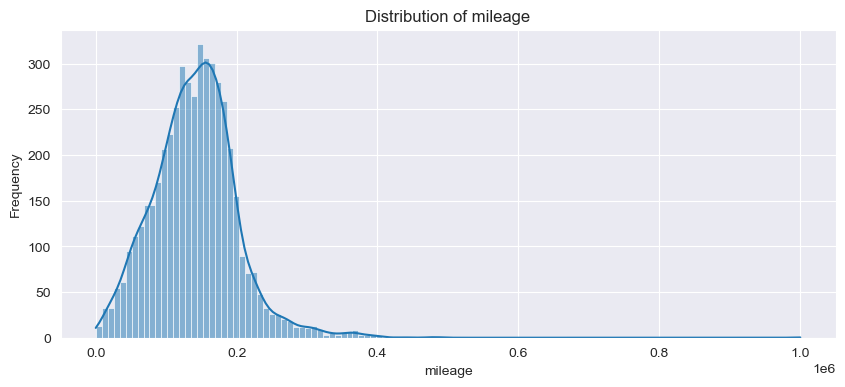

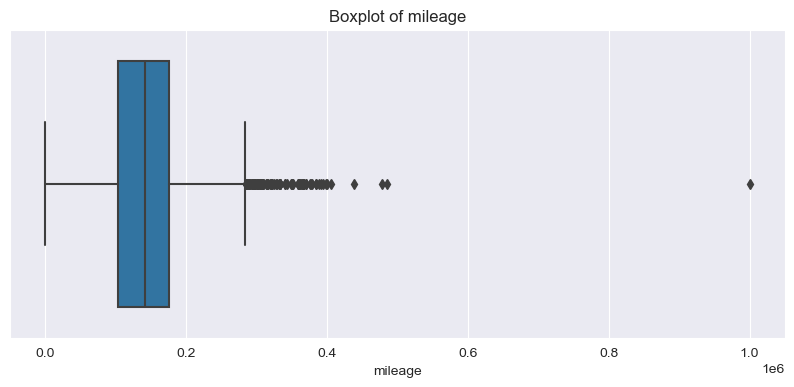

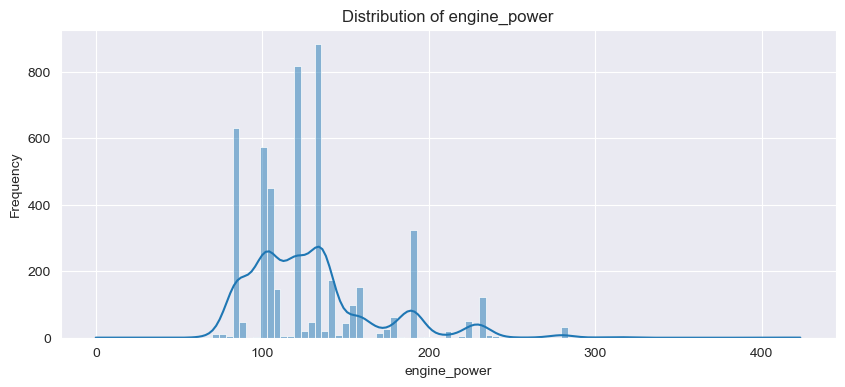

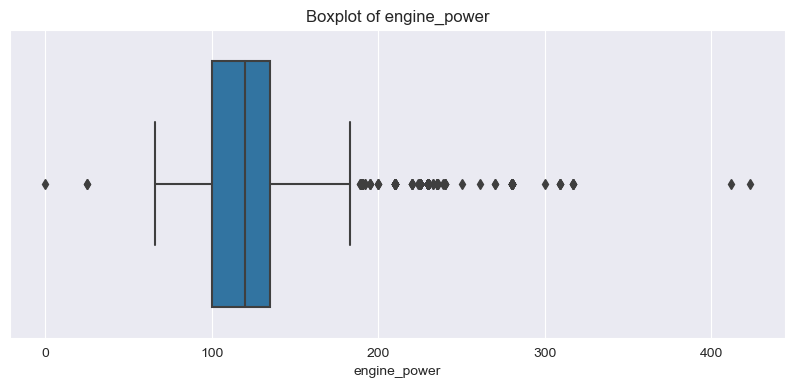

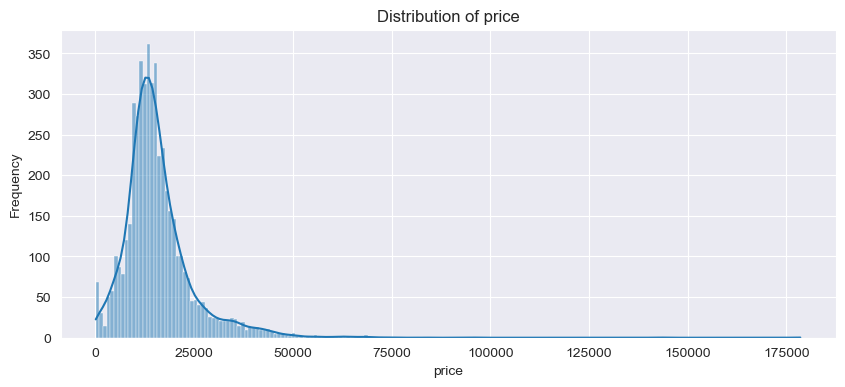

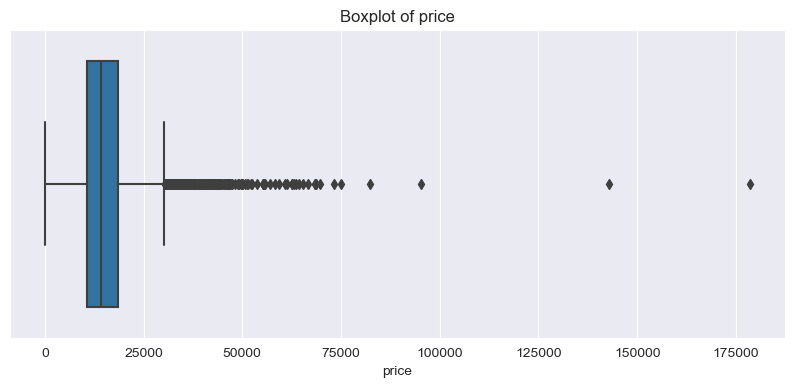

In [102]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

### 2.4. Histogram of categorical variables

Plot the histogram of the categorical features.

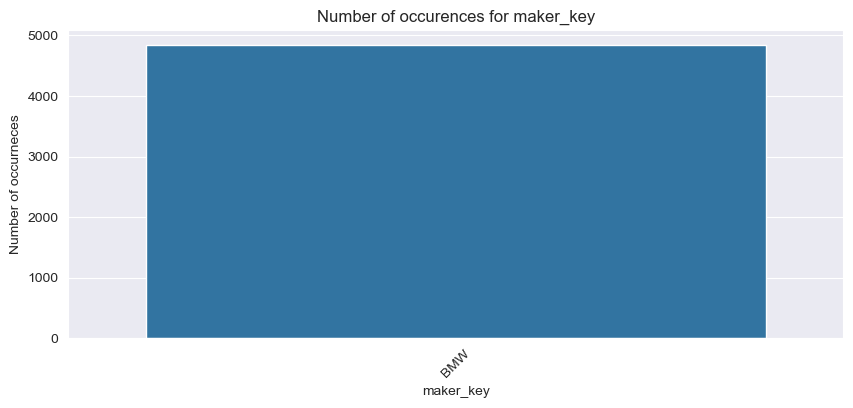

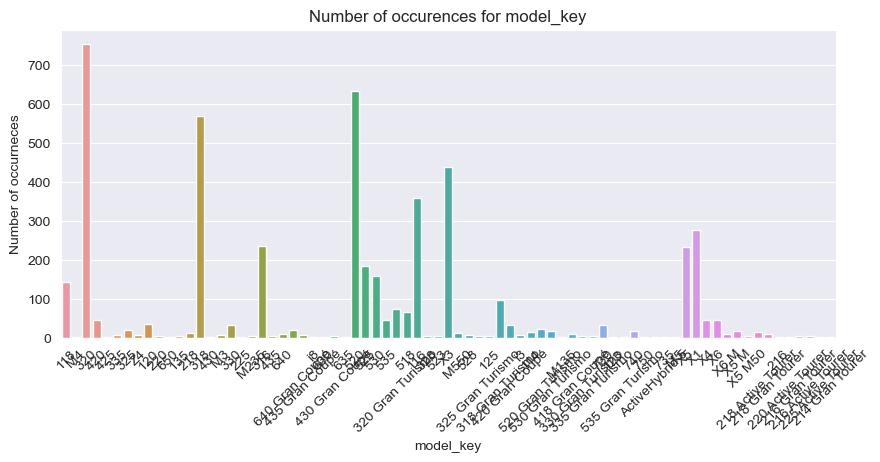

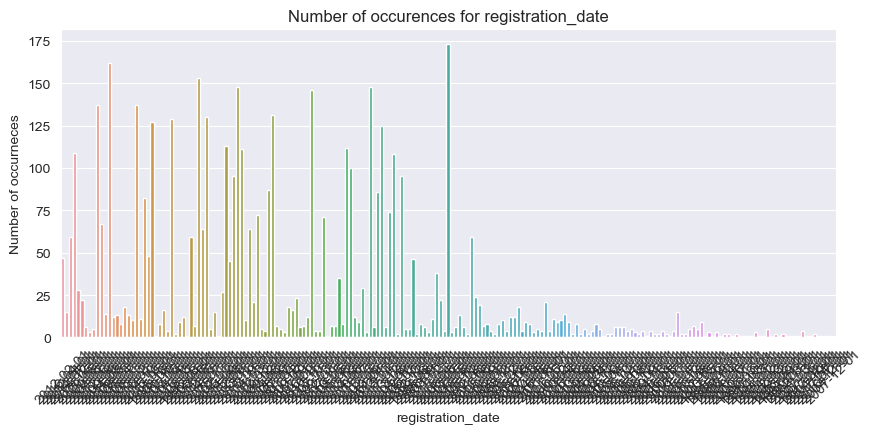

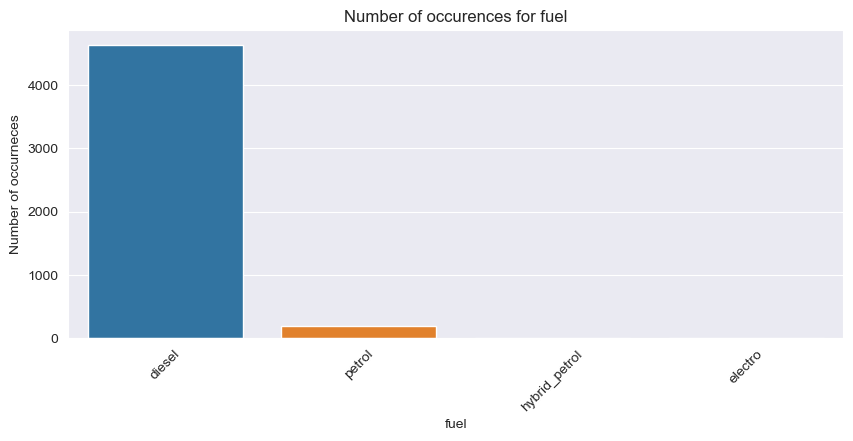

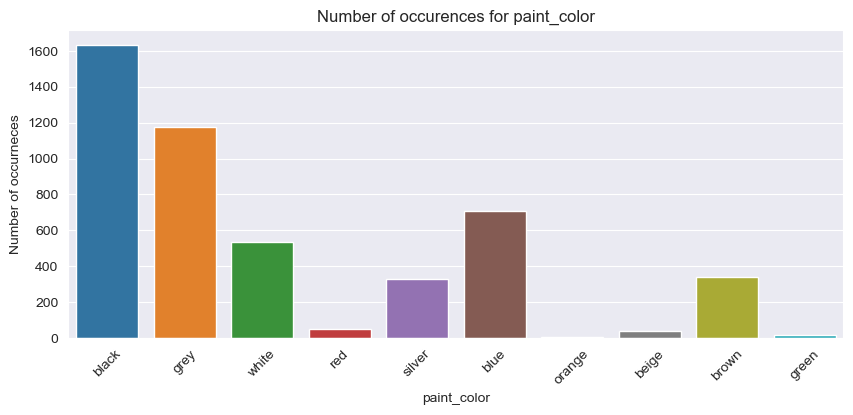

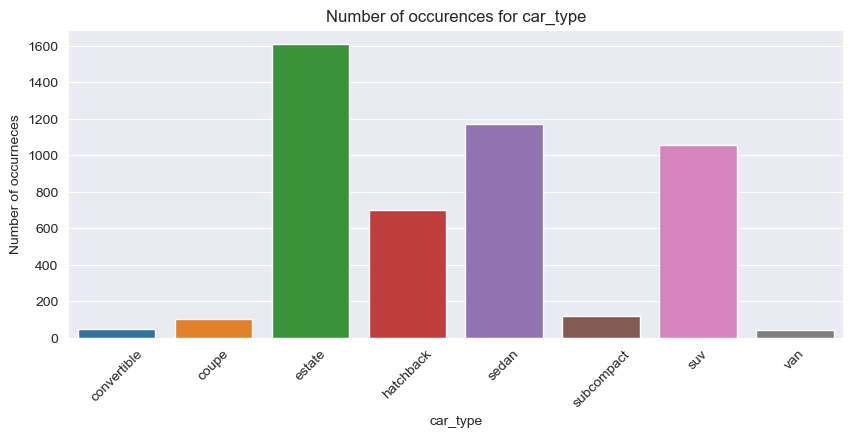

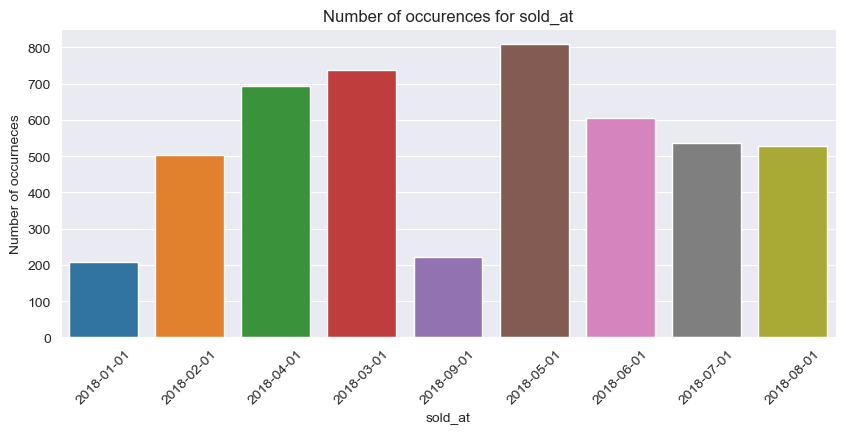

In [103]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Number of occurences for {col}')
    plt.xlabel(col)
    plt.ylabel('Number of occurneces')
    plt.xticks(rotation=45) 
    plt.show()

## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [104]:
X = df.drop('price', axis=1)  # Features (all columns except the target)
y = df['price']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Feature Engineering

### 4.1. Removing non-predictive features

Remove any unnecessary feature.

In [105]:
label_encoder = LabelEncoder()

# For each categorical column
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

df = pd.get_dummies(df, columns=categorical_columns)

# Now split your data into features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Assuming it's a classification problem. Use RandomForestRegressor for regression problem.
model = RandomForestClassifier()

# Fit the model
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Consider features with importance greater than a threshold (e.g., 0.01) or use other selection criteria
selected_features = feature_importance[feature_importance['importance'] > 0.01]['feature']

### 4.2. Creating new features

Creating polynomial features for numerical columns

In [107]:
# Assuming 'age' is the column in your DataFrame df representing the age of the cars
df['age_squared'] = df['mileage'] ** 2
df['is_new'] = np.where(df['mileage'] <= 1, 1, 0)
df['is_old'] = np.where(df['mileage'] >= 10, 1, 0)
df.head(10)

,mileage,engine_power,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,sold_at_2,sold_at_3,sold_at_4,sold_at_5,sold_at_6,sold_at_7,sold_at_8,age_squared,is_new,is_old
0,140411,100,True,True,False,False,True,True,True,False,...,False,False,False,False,False,False,False,19715248921,0,1
1,13929,317,True,True,False,False,False,True,True,True,...,False,False,False,False,False,False,False,194017041,0,1
2,183297,120,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,33597790209,0,1
3,128035,135,True,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,16392961225,0,1
4,97097,160,True,True,False,False,False,True,True,True,...,False,True,False,False,False,False,False,9427827409,0,1
5,152352,225,True,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,23211131904,0,1
6,205219,145,True,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,42114837961,0,1
7,115560,105,True,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,13354113600,0,1
8,123886,125,True,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,15347740996,0,1
9,139541,135,False,False,False,False,True,False,True,False,...,True,False,False,False,False,False,False,19471690681,0,1


### 4.3. Scaling numerical variables

In [109]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# List of numerical columns to scale
numerical_columns = ['price', 'mileage', 'engine_power']

# Fit to the data and transform it
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

### 4.4. Categorical variables encoding

Convert categorical columns into numerical columns using label encoding or one-hot encoding.

In [113]:
categorical_columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

df = pd.get_dummies(df, columns=categorical_columns)


### 4.5. Converting boolean columns

## 5. Linear Regression

Fit a linear regression model on the training set. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

Plot feature importance/weight.

## 6. Ridge

Fit a ridge regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

Plot feature importance/weight.

## 7. Lasso

Fit a lasso regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

Plot feature importance/weight.